In [1]:
import os
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("./Utils")
from utils import get_padded_loaders, load_checkpoint
from monai.networks.nets import UNETR

In [1]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

kwargs = {'train_dir': '../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': 3,
          'rotation': [-45, 45],
          'hflip_prob': 0.3,
          'brightness': [0.5, 1.5],
          'contrast': [0.5, 1.5],
          'gamma': [0.7, 1.3],
          'affine_prob': 0.4,
          'affine_translate': [0.05, 0.1],  # Horiz and vert translation
          'affine_scale': [1, 1.3],
          'affine_shears': [0, 0],
          'noise': (0, 0.2),  # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

NameError: name 'torch' is not defined

In [3]:
train_loader, val_loader = get_padded_loaders(**kwargs)

Feature batch shape: torch.Size([3, 3, 576, 576])
Labels batch shape: torch.Size([3, 576, 576])
The Train image numbers present in the batch are: ('34', '23', '31')


Text(0.5, 1.0, '34')

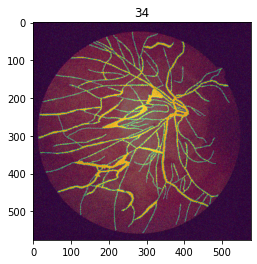

In [4]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

# Model 

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
day_and_run = "2022_04_03_1"
params = f"./Checkpoints_UNETR/{day_and_run}/training_params.pt"
logs = f"./Checkpoints_UNETR/{day_and_run}/training_logs.pt"
weights = f"./Checkpoints_UNETR/{day_and_run}/my_check.pth.tar"

In [6]:
logs = torch.load(logs)
params = torch.load(params)

In [7]:
params

{'LR': 0.002,
 'BATCH_SIZE': 1,
 'FEATURE_SIZE': 64,
 'NUM_EPOCHS': 1000,
 'LOSS_WEIGHTS': 1,
 'LOSS_FUNC': 'DICE+BCE_weights=1_ratio=0.7',
 'DROPOUT_RATE': 0.2,
 'ROTATION': [-15, 15],
 'HFLIP_PROB': 0.3,
 'BRIGHTNESS': [0.5, 1.5],
 'CONTRAST': [0.6, 1.5],
 'GAMMA': [0.7, 1.3],
 'AFFINE_PROB': 0.2,
 'AFFINE_TRANSLATE': [0.1, 0.1],
 'AFFINE_SCALE': [1, 1.25],
 'AFFINE_SHEARS': [0, 0],
 'NOISE': (0, 0.08),
 'DICE': 0.7976225916772268,
 'ACCURACY': 0.9656032986111112,
 'AUC': 0.9320922725210126}

In [4]:
print(logs["best_auc"])
print(logs["best_accuracy"])
print(logs["best_dice"])

0.9320922725210126
0.9656032986111112
0.7976225916772268


In [10]:
checkpoints_x = []
checkpoints_y = []
k = 0
for i,j in zip(logs['val_dice'], logs['saved']):
    if j:
        checkpoints_x.append(k)
        checkpoints_y.append(i)
    k+=1

In [22]:
import numpy as np
loss_avg = [np.mean(logs["loss"][i:i+16]) for i in range(0,len(logs["loss"]), 16)]

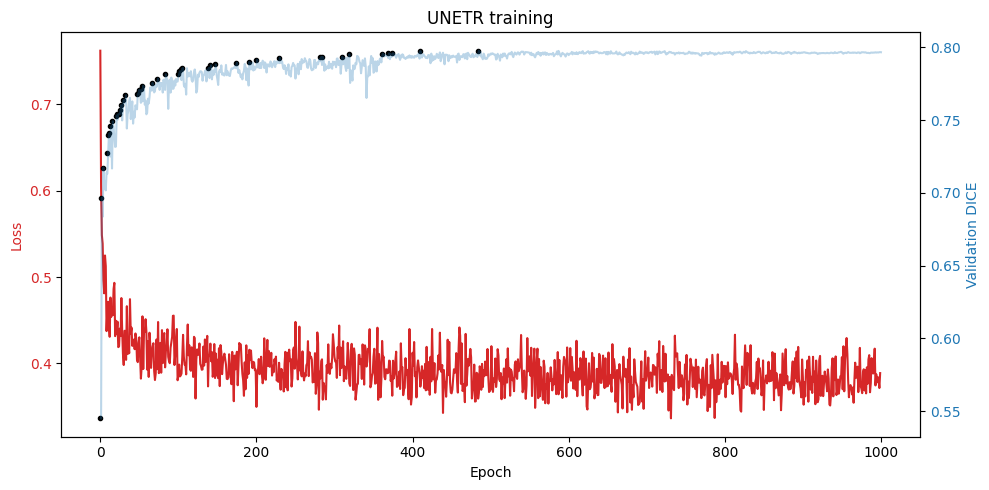

In [28]:
#Saco la media de las 4 imágenes (2 batches) para sacar el dice medio por epoch
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.dpi"] = 100
fig, ax1 = plt.subplots()
ax1.set_title("UNETR training")

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_avg)), loss_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation DICE', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, 1001, 1), logs['val_dice'], color=color, alpha=0.3)
ax2.scatter([i for i in checkpoints_x], checkpoints_y, color='k', marker=".")


ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Submission Grand Challenge

In [2]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test/images"

In [3]:
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
from PIL import Image, ImageOps
from torch.utils.data import Dataset
import torchvision

In [4]:
class DRIVE_dataset_padding (Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def transform_test(self, image):
        # Padding
        image = TF.pad(image, (5, 0, 6, 0), padding_mode="constant", fill=0) #left, top, right and bottom
        # Cropping
        image = ImageOps.crop(image, (0, 4, 0, 4))
        # Transform to tensor
        tens = ToTensor()
        image = tens(image)
        return image

    def __getitem__(self, index):

        number = self.images[index][0:2]
        image = f'{number}_test.tif'

        img_path = os.path.join(self.image_dir, image)

        img = Image.open(img_path).convert("RGB")

        # Fuerzo a 3 canales aunque solo sea uno para poder
        # aplicarle las mismas transformaciones
        img = self.transform_test(img)

        # Devuelvo solo 1 canal del label
        return img, number

def get_padded_loaders(
    test_dir,
    batch_size,
    num_workers,
    pin_memory
):

    test_ds = DRIVE_dataset_padding(
        image_dir=test_dir
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return test_loader

In [5]:
# Model Hyperparams
BATCH_SIZE = 20
FEATURE_SIZE = 64
DROPOUT_RATE = 0
test_loader = get_padded_loaders(TEST_IMG_DIR, BATCH_SIZE, 0, True)

In [10]:
model = UNETR(in_channels=3, out_channels=1, img_size=576, spatial_dims=2, feature_size=FEATURE_SIZE, dropout_rate=DROPOUT_RATE).to(DEVICE)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

104025025

In [13]:
load_checkpoint(torch.load(weights, map_location=torch.device(DEVICE)),
    model)
model.eval()
if not os.path.exists(f"../Data/dataset_DRIVE/submit_UNETR/{day_and_run}"):
    os.makedirs(f"../Data/dataset_DRIVE/submit_UNETR/{day_and_run}")
for i in test_loader:
    image = i[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(image))
        preds = (preds > 0.5).float()
        preds = TF.pad(preds, (0, 4, 0, 4), padding_mode="constant", fill=0)
        preds = preds[:, :, :, 5:570]
        torchvision.utils.save_image(
                preds, f"../Data/dataset_DRIVE/submit_UNETR/{day_and_run}/{i[1][0]}"+".png")


 => Loading checkpoint 


KeyboardInterrupt: 

# Generate images for UNETR

In [13]:
model = UNETR(in_channels=3, out_channels=1, img_size=576, spatial_dims=2, feature_size=FEATURE_SIZE, dropout_rate=DROPOUT_RATE).to(DEVICE)
load_checkpoint(torch.load(weights, map_location=torch.device(DEVICE)),
    model)
model.eval()

 => Loading checkpoint 


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU()
          (drop1): Dropout(p=0, inplace=False)
          (drop2): Dropout(p=0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (drop_output): Dropout(p=0, inplace=False)
          (drop_weights): Dropout(p=0, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1

In [29]:
problematic = next(iter(test_loader))[0][8]

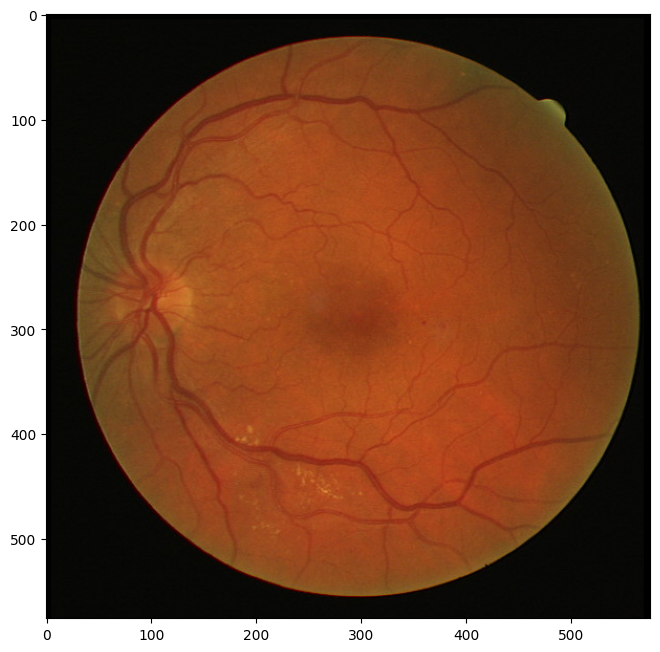

In [30]:
plt.imshow(problematic.squeeze(0).permute(1, 2, 0))

In [31]:
problematic = problematic.unsqueeze(0)
x = problematic.to(device=DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()

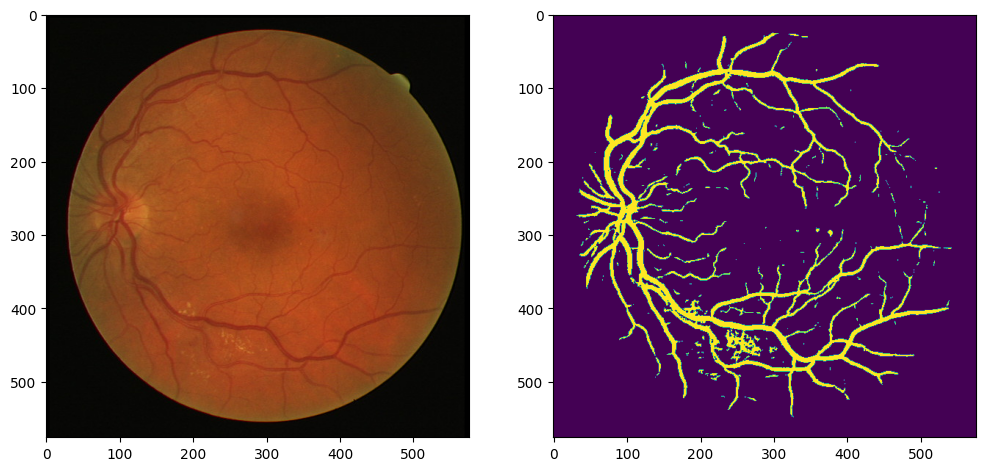

In [32]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots(1,2)
ax[0].imshow(problematic.squeeze(0).permute(1, 2, 0))
#ax[0].set_title("Original image")
ax[1].imshow(preds.squeeze(0).squeeze(0))
#ax[1].set_title("UNETR predictions")

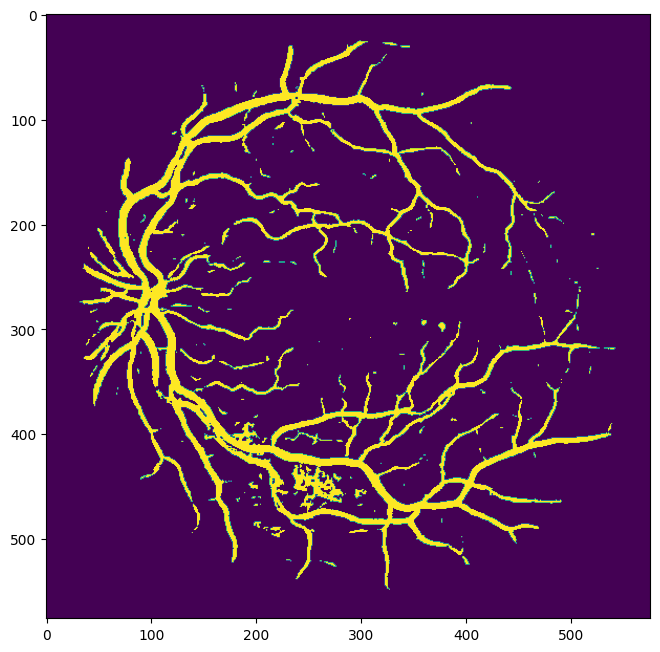

In [33]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100
plt.imshow(preds.squeeze(0).squeeze(0))